In [405]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import yfinance as yf

In [406]:
df = pd.read_csv('investment_fund_data_10M.csv').iloc[:,1:]
class_fund = pd.read_csv('fundo_classe.csv', sep = ';', encoding = 'ISO-8859-1')
selic = pd.read_csv("selic_historica.csv")
ibov = yf.download("^BVSP", start="2002-11-30", end="2022-12-3")

[*********************100%***********************]  1 of 1 completed


In [407]:
# Get percent changes in IBOV
ibov.reset_index(inplace = True)
ibov['year_month'] = ibov['Date'].dt.to_period('M')
ibov = ibov.groupby('year_month')['Open'].mean()
# Get month/month percent dufference
ibov = ibov.pct_change(periods=1)

In [408]:
# Filter for values between Dec/2002 to Dec/2022
df = df.drop(['2002-01', '2002-02', '2002-03', '2002-04', '2002-05', '2002-06', '2002-07', '2002-08',
             '2002-09', '2002-10', '2002-11'], axis = 1) # '2002-01', 

In [409]:
# Keep only funds that did not change their classification and that are fundos de ação
class_fund.drop_duplicates('CNPJ_FUNDO', keep = False, inplace = True)
class_fund = class_fund[class_fund.CLASSE == 'Fundo de Ações']

In [410]:
# Merge with investment_fund_data
fundos = df.merge(class_fund[['CNPJ_FUNDO']], on = 'CNPJ_FUNDO')
fundos.set_index('CNPJ_FUNDO',  inplace = True)

In [411]:
# Correct weird effect where some funds have results for 12-2002 but not again for some time
fundos.loc[fundos['2003-01'].isna(), '2002-12'] = np.NaN

In [412]:
# Find the first and last column with a non-null value for each row
fundos['first_value'] = pd.to_datetime(fundos.notnull().idxmax(axis=1))
fundos['last_value'] = pd.to_datetime(fundos.notnull().idxmin(axis=1))

# Get first and last quotes
fundos['first_quote'] = fundos.iloc[:,:-2].apply(lambda x: x[x > 0].at[x[x > 0].first_valid_index()], axis=1)
fundos['last_quote'] = fundos.iloc[:,:-3].apply(lambda x: x[x > 0].at[x[x > 0].last_valid_index()], axis=1)
fundos["absolute_change"] = fundos['last_quote']/fundos['first_quote'] - 1


# Find the last column with a non-null value for each row, starting from the right
fundos['last_value_from_right'] = fundos.iloc[:, :241].loc[:, ::-1].notnull().idxmin(axis=1)
fundos['first_value_from_right'] = fundos.iloc[:, :241].loc[:, ::-1].notnull().idxmax(axis=1)

# Convert the first_value and last_value columns to datetime
#fundos['first_value'] = pd.to_datetime(fundos['first_value'])
#fundos['last_value'] = pd.to_datetime(fundos['last_value'])

# Replace the last_value for rows where it is equal to 2002-12-01 with the last_value_from_right
fundos.loc[fundos['last_value'] == pd.to_datetime('2002-12-01'), 'last_value'] = fundos['first_value_from_right']
fundos['last_value'] = pd.to_datetime(fundos['last_value'])

# Drop the last_value_from_right column
fundos.drop(['last_value_from_right', 'first_value_from_right'], axis=1, inplace=True)

<AxesSubplot:>

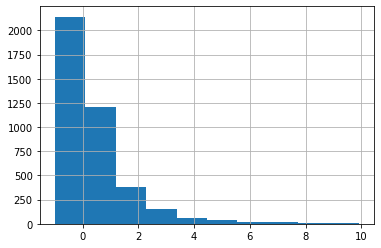

In [413]:
fundos[fundos.absolute_change < 10]['absolute_change'].hist()

In [414]:
# Filter for funds that existed prior to 2012-12-01 and existed for longer than one year
#fundos = fundos[fundos.first_value <= pd.to_datetime('2012-12-01')] - should I remove these guys?
fundos['months_existing'] = ((fundos['last_value'] - fundos['first_value'])/np.timedelta64(1, 'M')).astype(int)
fundos = fundos[fundos['months_existing'] > 12]

In [415]:
# Compute average Risk Free Rate and Market Rate while the fund existed
fundos = fundos.reset_index()
selic['Date'] = pd.to_datetime(selic['Date'])
selic.set_index('Date', inplace = True)
selic_averages = []
ibov_averages = []
for index, row in fundos.iterrows():
    start_date = row['first_value']
    end_date = row['last_value']
    average_selic = selic.loc[start_date:end_date].mean().Rate
    selic_averages.append(average_selic)
    average_ibov = pd.DataFrame(ibov).loc[start_date:end_date].mean().Open
    ibov_averages.append(average_ibov)
fundos["mean_monthly_selic"] = selic_averages
fundos["mean_monthly_ibov"] = ibov_averages


In [416]:
# Compute Mean, Std and Sharpe of each fund
fundos = fundos.set_index('CNPJ_FUNDO')
returns = fundos.iloc[:, :241]/fundos.iloc[:, :241].shift(1, axis = 1)-1 
returns.replace([np.inf, -np.inf], np.NaN, inplace=True)
returns = returns.clip(upper=2) # Caping because of data entry errors
returns['mean_monthly_return'] = returns.mean(axis = 1, skipna = True, numeric_only = True)
returns['std_monthly_return'] = returns.std(axis = 1, skipna = True)
#returns['sharpe'] = returns['mean_return']/returns['std_return']
fundos.reset_index(inplace = True)
returns.reset_index(inplace = True)
fundos = fundos.merge(returns[['CNPJ_FUNDO', 'mean_monthly_return', 'std_monthly_return']], on = 'CNPJ_FUNDO') # 2 funds that had no change over time drop out
fundos['sharpe'] = (fundos['mean_monthly_return'] - fundos['mean_monthly_selic'])/fundos['std_monthly_return'] # check this

<AxesSubplot:>

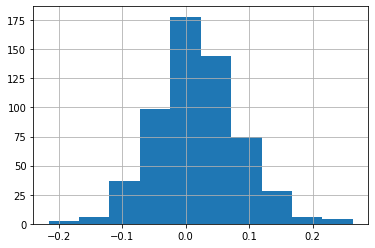

In [417]:
fundos[fundos.months_existing >= 120]['sharpe'].hist()

In [419]:
def computeBeta(df_portfolio_returns, df_ibov):

    first_valid_idx = returns.iloc[:, 1:241].apply(lambda x: df_portfolio_returns.iloc[:, 1:241].columns.get_loc(x.first_valid_index()), axis=1).values
    last_valid_idx = returns.iloc[:, 1:241].apply(lambda x: df_portfolio_returns.iloc[:, 1:241].columns.get_loc(x.last_valid_index()), axis=1).values


    betas = []
    # Get Beta for each row
    for i, row in df_portfolio_returns.iterrows():
        corr_e_m = np.corrcoef(ma.masked_invalid(row[first_valid_idx[i]+1:last_valid_idx[i]+1].astype(float)), ma.masked_invalid(df_ibov[first_valid_idx[i]:last_valid_idx[i]]))[0][1]
        std_e = np.std(returns.iloc[i, first_valid_idx[i]:last_valid_idx[i]].astype(float))
        std_m = np.std(df_ibov[first_valid_idx[i]:last_valid_idx[i]])
        beta = corr_e_m*std_e/std_m
        betas.append(beta)
    return betas

In [420]:
returns['beta'] = computeBeta(returns, ibov)

In [421]:
# Investigate why nulls intervalues happen later
returns = returns[~returns.beta.isna()]

In [422]:
# Merge Returns dataframe to fundos and compute alpha for each equity fund
fundos = fundos.merge(returns[['CNPJ_FUNDO', 'beta']], on = 'CNPJ_FUNDO')


In [423]:
fundos['alpha'] = fundos['mean_monthly_return'] - fundos['mean_monthly_selic'] - fundos['beta']*(fundos['mean_monthly_ibov'] - fundos['mean_monthly_selic'])

<AxesSubplot:>

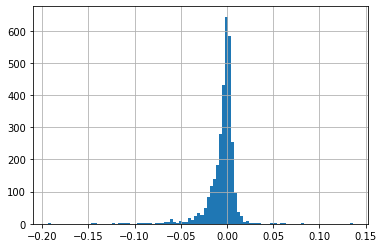

In [424]:
fundos['alpha'].hist(bins = 100)

In [425]:
fundos.sort_values('alpha')

,CNPJ_FUNDO,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,...,last_quote,absolute_change,months_existing,mean_monthly_selic,mean_monthly_ibov,mean_monthly_return,std_monthly_return,sharpe,beta,alpha
3121,42.747.365/0001-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.595455e-08,-1.000000,17,0.008228,-0.006971,-0.263168,0.360485,-0.752864,5.129908,-0.193430
3148,43.274.412/0001-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.375438e+00,-0.762456,13,0.008600,-0.003568,-0.136538,0.300495,-0.482997,-0.173457,-0.147249
3138,43.096.273/0001-94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.600111e-02,-0.953979,15,0.008331,-0.006226,-0.131956,0.333783,-0.420293,-0.166852,-0.142716
1276,19.445.247/0001-40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.448932e-02,-0.985522,22,0.009896,0.003667,-0.121360,0.211715,-0.619966,1.354699,-0.122818
2945,40.269.224/0001-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.906333e+02,-0.609367,16,0.006688,-0.000825,-0.113138,0.249073,-0.481088,0.650367,-0.114940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,03.243.528/0001-80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.358122e+03,-0.058071,17,0.013305,0.011343,0.075361,0.501562,0.123724,-4.518900,0.053188
2234,33.150.298/0001-75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.098988e+00,4.787737,33,0.005332,0.002218,0.061706,0.125045,0.450824,0.937367,0.059293
2678,30.773.639/0001-70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.017016e+03,3.038605,22,0.006700,-0.000299,0.065152,0.075438,0.774844,0.479852,0.061811
1985,32.652.242/0001-56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.732724e+04,10.137215,36,0.005145,0.004256,0.084301,0.192793,0.410578,1.625327,0.080601


In [426]:
(fundos[fundos.months_existing > 180]['mean_monthly_return'] > fundos[fundos.months_existing > 180]['mean_monthly_selic']).mean()

0.6440677966101694

In [427]:
(fundos['mean_monthly_return'] > fundos['mean_monthly_selic']).mean()

0.41135426577862355

In [428]:
(fundos['mean_monthly_return'] > fundos['mean_monthly_ibov']).mean()

0.41135426577862355

In [429]:
(fundos['alpha'] > 0.005).mean()

0.11195686647637171

In [ ]:
# 2 cool plots:
- prob of returning given alpha
- survivor function

# Survival Analysis

## Survivor Function

In [550]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

In [551]:
fundos['Exited'] = fundos['last_value'] < pd.to_datetime('2022-11-01')

In [552]:
kmf.fit(fundos["months_existing"], fundos['Exited'], label="Kaplan-Meier Estimate")

<lifelines.KaplanMeierFitter:"Kaplan-Meier Estimate", fitted with 3153 total observations, 2157 right-censored observations>

Text(0.5, 0, "Fund's Age (months)")

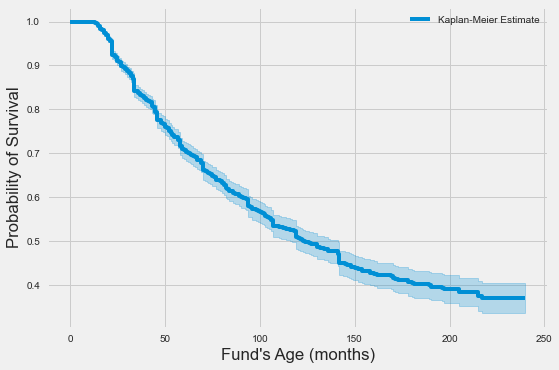

In [553]:
kmf.plot()
plt.ylabel("Probability of Survival")
plt.xlabel("Fund's Age (months)")

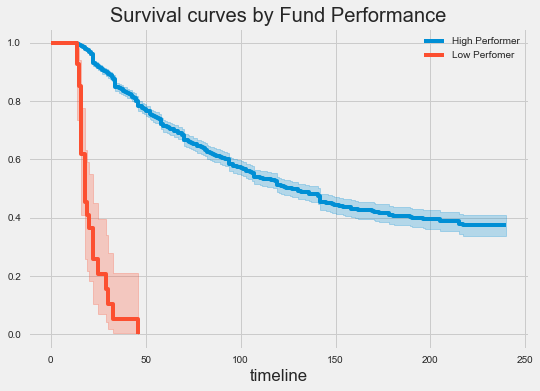

In [554]:
fundos["performance_group"] = pd.cut(fundos["mean_monthly_return"], bins = 2, labels = ["Low Perfomer", "High Performer"])
T = fundos['months_existing']
E = fundos['Exited']
ax = plt.subplot(111)
for perf_group in fundos['performance_group'].unique():
    
    flag = fundos['performance_group'] == perf_group
    
    kmf.fit(T[flag], event_observed=E[flag], label=perf_group)
    kmf.plot(ax=ax)

plt.title("Survival curves by Fund Performance");

In [57]:
fundos['alpha'].head(20)

0     0.000144
1    -0.002881
2    -0.024581
3      0.00277
4     0.003071
5    -0.105755
6    -0.018469
7     0.000861
8    -0.002299
9     0.003026
10    0.004817
11   -0.000903
12   -0.000085
13    0.005137
14    0.001044
15    0.002042
16          --
17    0.002627
18    0.004715
19    0.001236
Name: alpha, dtype: object

In [43]:
kmf.fit(fundos["alpha"], fundos['Exited'], label="Kaplan-Meier Estimate")
kmf.plot()
plt.ylabel("Probability of Survival")
plt.xlabel("Fund's Age (months)")

C:\Users\mathe\anaconda3\lib\site-packages\lifelines\utils\__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
C:\Users\mathe\anaconda3\lib\site-packages\lifelines\utils\__init__.py:1189: UserWarning: Warning: converting a masked element to nan.
  infs = np.isinf(df_or_array.astype(float))


ValueError: Values must be numeric: no strings, datetimes, objects, etc.

## Hazard Function

In [919]:
from lifelines import NelsonAalenFitter

<AxesSubplot:xlabel='timeline'>

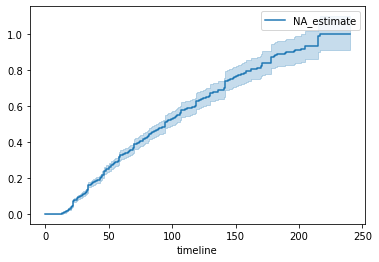

In [920]:
naf = NelsonAalenFitter()
naf.fit(fundos["months_existing"], event_observed=fundos['Exited'])

naf.plot()

## Correlation between Months of Existence and return

In [ ]:
# Correlation between months_existing and sharpe
fundos['bin_months_existing'] = pd.cut(fundos['months_existing'], 
                                       bins = [0, 50, 100, 150, 200, 250],
                                       labels = ['50 or less', '50 to 100', '100 to 150', '150 to 200', '200 to 250'])

Text(0.5, 0, 'Months of Existence')

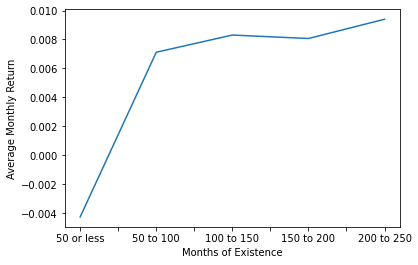

In [921]:
fundos.groupby('bin_months_existing')['mean_monthly_return'].mean().plot()
plt.ylabel('Average Monthly Return')
plt.xlabel('Months of Existence')

# Normality Tests

## Visual Comparison

In [922]:
mean = fundos['sharpe'].mean()  # mudar pra ibov
std = fundos['sharpe'].std() # mudar pra ibov
x = np.random.normal(mean, std, 1000)

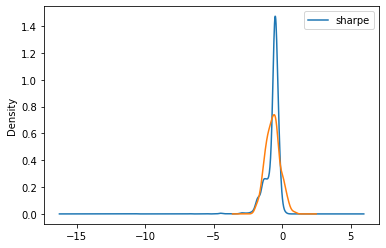

In [923]:
# Distribution of Sharpe
fundos['sharpe'].plot.kde(legend = 'Empirical Distribution')
pd.Series(x).plot.kde(legend = 'Normal Distribution')
#plt.hist(x, bins = 10000)
plt.legend()

## QQ Plot

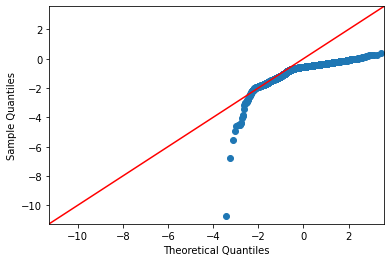

In [924]:
import math
from scipy.stats import lognorm
import statsmodels.api as sm

#make this example reproducible
np.random.seed(1)

#generate dataset that contains 1000 log-normal distributed values
#lognorm_dataset = lognorm.rvs(s=.5, scale=math.exp(1), size=1000)

#create Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(fundos['sharpe'], line='45')

plt.show()

## Shapiro-Wilk Test

In [925]:
from scipy.stats import shapiro 

In [926]:
shapiro(fundos['sharpe'])

ShapiroResult(statistic=0.7388767004013062, pvalue=0.0)

## KS Test

In [927]:
from scipy.stats import kstest

In [928]:
kstest(fundos['sharpe'], 'norm')

KstestResult(statistic=0.5258648717511707, pvalue=0.0)

In [929]:
# Are all funds in investment_fund_data in fundo_classe? No. 1264 CNPJs no investment_fund nao encontrados no fundo_classe. 
# Removed 6,011 funds because they either are not in fundo_classe or changed their classe over time
# 3915 funds were removed because they were less than 10 years old

In [930]:
# Why do some have NaNs and then have data again? Check funds that are inactive and remove them at that date
# Plot funds that are dieing out (check that these indeed have lower performance)
# Plot distribution of Sharpe, Return and Volatility
# Normality test

# Portfolio Simulation

In [217]:
selected_stocks = "BBDC3.SA ELET3.SA PETR3.SA VALE3.SA EMBR3.SA GGBR3.SA ITUB3.SA ABEV3.SA CMIG3.SA USIM3.SA ITSA3.SA OIBR3.SA VIVT3.SA"

In [280]:
# Retrieve data
stocks = yf.download(selected_stocks, start="2002-11-29", end="2022-12-01") # 100 largest stocks in 2023

# Normalize data
stocks = stocks.div(stocks.iloc[0])

# Fill NaNs for PETR3.SA with immediate previous value
stocks = stocks.ffill()

# Fix first date to avoid merge issues
stocks = stocks.reset_index().replace({'2002-11-29':'2002-12-01'})#.set_index('Date')

# Change to monthly aggregation level
stocks = stocks[['Date', 'Adj Close']]
stocks['month_year'] = stocks['Date'].dt.to_period('M')
stocks['month_year'] = pd.to_datetime(stocks['month_year'].astype(str))
stocks = stocks.drop('Date', axis = 1)
stocks = pd.DataFrame(stocks.groupby('month_year').mean())
stocks.columns = stocks.columns.droplevel(0)
stocks.reset_index(inplace = True)

[*********************100%***********************]  13 of 13 completed


In [341]:
df_ibov = pd.DataFrame(ibov).reset_index()#[ibov.year_month > pd.to_datetime('2003-01')]

In [342]:
df_ibov['year_month'] = pd.to_datetime(df_ibov['year_month'].astype(str))

In [343]:
df_ibov = df_ibov.rename(columns = {'year_month':'month_year'})#[df_ibov.month_year > pd.to_datetime('2010-09')]

In [344]:
df_ibov

,month_year,Open
0,2002-12-01,NaN
1,2003-01-01,0.064223
2,2003-02-01,-0.097439
3,2003-03-01,0.046382
4,2003-04-01,0.107503
...,...,...
236,2022-08-01,0.110203
237,2022-09-01,0.007526
238,2022-10-01,0.042654
239,2022-11-01,-0.026599


In [431]:
fundos#.iloc[:,-80:]

,CNPJ_FUNDO,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,...,last_quote,absolute_change,months_existing,mean_monthly_selic,mean_monthly_ibov,mean_monthly_return,std_monthly_return,sharpe,beta,alpha
0,01.715.238/0001-66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.069810,2.215978,70,0.011026,0.018695,0.018865,0.066078,0.118627,1.003318,0.000144
1,02.027.439/0001-33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2471.845708,-0.225810,142,0.009641,0.006975,0.004322,0.083528,-0.063682,0.914756,-0.002881
2,02.138.445/0001-68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6418.545967,1.110502,43,0.012327,0.023492,-0.003113,0.166212,-0.092893,0.818668,-0.024581
3,02.205.515/0001-53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.299177,7.388955,226,0.008438,0.009159,0.011214,0.064717,0.042891,0.008356,0.002770
4,02.228.453/0001-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.057198,1.800098,106,0.009329,0.008247,0.011378,0.057646,0.035557,0.944280,0.003071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3148,43.274.412/0001-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.375438,-0.762456,13,0.008600,-0.003568,-0.136538,0.300495,-0.482997,-0.173457,-0.147249
3149,43.508.203/0001-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.910611,-0.089837,14,0.008762,-0.003657,-0.006139,0.015052,-0.989969,-0.053314,-0.015564
3150,43.508.965/0001-00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.992522,0.000256,13,0.009053,-0.000467,0.002231,0.067500,-0.101066,1.246926,0.005050
3151,43.508.989/0001-51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.390438,-0.609417,13,0.009053,-0.000467,-0.055323,0.122537,-0.525360,-0.425753,-0.068430


In [488]:
def samplePortfolioWeights(n_stocks, n_rows):
    """
    """
    sampled_weights_df = pd.DataFrame(np.random.dirichlet(np.ones(n_stocks),size=n_rows))
    sampled_weights_df.columns = ['ABEV3.SA', 'BBDC3.SA', 'CMIG3.SA', 'ELET3.SA',
                                   'EMBR3.SA', 'GGBR3.SA', 'ITSA3.SA', 'ITUB3.SA',
                                   'OIBR3.SA', 'PETR3.SA', 'USIM3.SA', 'VALE3.SA',
                                   'VIVT3.SA']
    return sampled_weights_df

def iterateRows(funds_df, ibov_series, stocks_df):
    """
    """
    # Fix ibov_df
    ibov_df = pd.DataFrame(ibov_series).reset_index()
    ibov_df['month_year'] = pd.to_datetime(ibov_df['month_year'].astype(str))
    
    p_vals = []
    for index, row in funds_df.iterrows():
        p_val = computePValue(row, ibov_df, stocks_df)
        p_vals.append(p_val)
    #funds_df.iloc[:10]['p_vals'] = p_vals
    return p_vals


def computePValue(row_df, ibov_df, stocks_df):
    """
    """
    first_date = row_df['first_value']
    mean_monthly_selic = row_df['mean_monthly_selic'] 
    mean_monthly_ibov = row_df['mean_monthly_ibov']
    alpha = row_df['alpha']
    
    sampled_weights_df = samplePortfolioWeights(13, 1000)
    sampled_weights_df = computeBeta(sampled_weights_df, first_date, ibov_df, stocks_df)
    # Compute alpha distribution
    sampled_weights_df['mean_monthly_selic'] = mean_monthly_selic
    sampled_weights_df['mean_monthly_ibov'] = mean_monthly_ibov
    sampled_weights_df['alpha'] = sampled_weights_df['mean_monthly_return_portfolio'] - sampled_weights_df['mean_monthly_selic'] -  sampled_weights_df['beta']*(sampled_weights_df['mean_monthly_ibov'] - sampled_weights_df['mean_monthly_selic'])
    # Compute p-value
    p_val = np.mean(alpha >= sampled_weights_df['alpha'])
    return p_val

def computeBeta(sample_weights_df, first_date, ibov_df, stocks_df):
    # Make this 
    """ """
    mean_monthly_return_portfolio_array = []
    beta_array = []
    

    std_m = np.std(ibov_df[ibov_df.month_year >= first_date]['Open'])
    for i, row in sample_weights_df.iterrows():
        # Compute r_e for each synthetic porfolio
        total_return_df = stocks_df[stocks_df.month_year >= first_date].drop('month_year', axis = 1).dot(sampled_weights_df.iloc[i:i+1,:].T)
        monthly_return_df = total_return_df/total_return_df.shift(1) - 1
        monthly_return_df.columns = ['monthly_return']
        mean_monthly_return_portfolio = monthly_return_df['monthly_return'].mean()
        corr_e_m = np.corrcoef(ma.masked_invalid(monthly_return_df[1:]['monthly_return']),ma.masked_invalid(ibov_df[ibov_df.month_year > first_date][1:]['Open']))[0][1]
        std_e = np.std(monthly_return_df['monthly_return'])
        beta = corr_e_m*std_e/std_m
        mean_monthly_return_portfolio_array.append(mean_monthly_return_portfolio)
        beta_array.append(beta)
    
    sample_weights_df['beta'] = beta_array
    sample_weights_df['mean_monthly_return_portfolio'] = mean_monthly_return_portfolio_array
    
    return sample_weights_df

# add rf and rm to the sample_weights_df and the compute alpha

'''
mult_df = pd.DataFrame()
    for col1, col2 in zip(sampled_weights_df.columns, div_df.columns):
        mult_df[col1.replace('w', 'return')] = sampled_weights_df[col1]*div_df[col2]
'''
    

"\nmult_df = pd.DataFrame()\n    for col1, col2 in zip(sampled_weights_df.columns, div_df.columns):\n        mult_df[col1.replace('w', 'return')] = sampled_weights_df[col1]*div_df[col2]\n"

In [320]:
sample_weights_df = samplePortfolioWeights(13, 1000)

In [441]:
fundos.iloc[0,:]

CNPJ_FUNDO             01.715.238/0001-66
2002-12                               NaN
2003-01                               NaN
2003-02                               NaN
2003-03                               NaN
                              ...        
mean_monthly_return              0.018865
std_monthly_return               0.066078
sharpe                           0.118627
beta                             1.003318
alpha                            0.000144
Name: 0, Length: 255, dtype: object

In [497]:
pval_dist = iterateRows(fundos, df_ibov, stocks)

In [544]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [547]:
plt.style.use('fivethirtyeight')

Text(0, 0.5, 'Density')

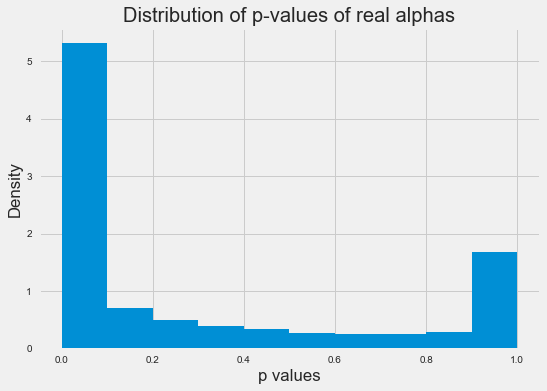

In [548]:
plt.hist(pval_dist, density = True)
plt.title("Distribution of p-values of real alphas")
plt.xlabel("p values")
plt.ylabel("Density")

In [520]:
(np.array(pval_dist) < 0.1).mean()

0.5306057722803679

In [502]:
fundos['p_val'] = pval_dist

In [540]:
(fundos[fundos.months_existing <= 120]['p_val'] > 0.95).mean()

0.10357675111773472

In [537]:
(fundos[fundos.months_existing >= 120]['p_val'] > 0.95).mean()

0.4267515923566879

In [524]:
fundos[fundos.p_val == 1][fundos.months_existing >= 120].sort_values('alpha').tail(10)#.to_csv("fundos_final.csv")

<ipython-input-524-d10fd90e3dbb>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fundos[fundos.p_val == 1][fundos.months_existing >= 120].sort_values('alpha').tail(10)#.to_csv("fundos_final.csv")


,CNPJ_FUNDO,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,...,absolute_change,months_existing,mean_monthly_selic,mean_monthly_ibov,mean_monthly_return,std_monthly_return,sharpe,beta,alpha,p_val
893,13.401.215/0001-66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.446045,130,0.007014,0.006739,0.016330,0.042332,0.220066,-0.129568,0.009280,1.0
626,11.188.572/0001-62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.880478,157,0.007238,0.005596,0.015735,0.046587,0.182400,0.671958,0.009600,1.0
506,09.288.254/0001-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.746390,177,0.007448,0.005149,0.015212,0.057448,0.135142,0.848447,0.009714,1.0
516,09.412.648/0001-40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.876373,177,0.007448,0.005149,0.016016,0.045363,0.188869,0.621468,0.009996,1.0
712,11.538.190/0001-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.847996,153,0.007256,0.005023,0.016098,0.171117,0.051671,0.983964,0.011040,1.0
536,09.577.036/0001-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13.591973,169,0.007357,0.006425,0.017604,0.057808,0.177260,0.850059,0.011040,1.0
192,06.988.623/0001-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,45.316012,218,0.008293,0.009134,0.020886,0.144518,0.087139,0.870368,0.011861,1.0
190,06.871.950/0001-78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.349592,126,0.009408,0.008285,0.021624,0.134036,0.091136,1.000731,0.013340,1.0
838,14.568.718/0001-93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.471278,132,0.007030,0.006721,0.023120,0.101956,0.157814,1.015603,0.016404,1.0
448,08.935.128/0001-59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,117.591315,185,0.007510,0.005827,0.026030,0.181253,0.102181,1.584476,0.021187,1.0


In [390]:
test_df = computeAlphasDistribution(sample_weights_df, pd.to_datetime('2012-10-01'), df_ibov)

<AxesSubplot:>

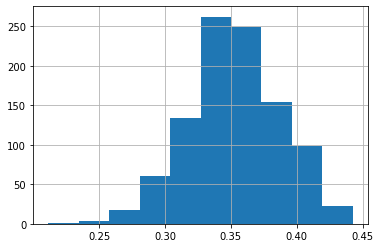

In [392]:
test_df['beta'].hist()

In [398]:
computePValue(pd.to_datetime('2012-10-01'), 0.01, df_ibov)

C:\Users\mathe\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


ABEV3.SA                         0.122
BBDC3.SA                         0.119
CMIG3.SA                         0.117
ELET3.SA                         0.107
EMBR3.SA                         0.117
GGBR3.SA                         0.119
ITSA3.SA                         0.105
ITUB3.SA                         0.127
OIBR3.SA                         0.110
PETR3.SA                         0.121
USIM3.SA                         0.116
VALE3.SA                         0.110
VIVT3.SA                         0.128
beta                             0.000
mean_monthly_return_portfolio    0.841
dtype: float64

In [282]:
portfolio_start_date = pd.to_datetime('2002-12-01')
sampled_weights_df = samplePortfolioWeights(13, 1000)
#div_df = pd.concat([pd.DataFrame(fundos).T]*1000).reset_index().drop('index', axis = 1)
tolerance = pd.Timedelta('1M')
fundos = pd.merge_asof(fundos, stocks, left_on = 'first_value', right_on = 'month_year', tolerance=tolerance)

<ipython-input-282-bbc37378e88f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stocks['month_year'] = stocks['Date'].dt.to_period('M')
<ipython-input-282-bbc37378e88f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stocks['month_year'] = pd.to_datetime(stocks['month_year'].astype(str))
<ipython-input-282-bbc37378e88f>:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  stocks = stocks.drop('Date', axis = 1)
<ipython-input-282-bbc37378e88f>:

In [299]:
stocks

,month_year,ABEV3.SA,BBDC3.SA,CMIG3.SA,ELET3.SA,EMBR3.SA,GGBR3.SA,ITSA3.SA,ITUB3.SA,OIBR3.SA,PETR3.SA,USIM3.SA,VALE3.SA,VIVT3.SA
0,2002-12-01,0.982687,1.031470,1.029322,1.092419,1.007708,1.078412,1.000659,1.064605,0.997381,1.057681,1.001050,1.028830,0.960156
1,2003-01-01,0.930480,1.119531,1.081901,1.090700,0.938619,1.119707,1.000000,1.111451,0.986175,1.121359,1.095278,0.948917,0.916556
2,2003-02-01,0.904415,1.004286,0.943023,0.878779,0.721112,1.061688,1.005758,1.038732,0.887644,1.037052,1.101294,1.014540,0.911160
3,2003-03-01,0.944204,1.088133,0.921373,0.895658,0.620544,1.148918,0.997403,1.121730,0.957189,1.050308,1.127012,0.968662,0.948057
4,2003-04-01,1.002969,1.164502,1.024313,1.062426,0.708300,1.141500,0.988568,1.258322,1.035389,1.083314,1.424452,0.863446,0.982382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-07-01,14.692723,15.533534,20.617195,10.351057,1.104576,11.475142,10.523321,15.045030,0.008369,9.712364,8.291109,16.717644,5.757291
236,2022-08-01,15.531124,17.285801,24.099128,11.090861,1.336728,12.663564,11.190230,16.956881,0.009335,12.692517,8.691597,16.472751,5.472351
237,2022-09-01,15.800108,17.672820,22.697459,10.450636,1.250335,12.731442,11.509305,17.813107,0.007972,12.785227,8.212760,16.678826,5.119833
238,2022-10-01,15.671721,18.333590,22.219204,10.833758,1.192403,13.805486,12.482122,19.029233,0.005286,13.690271,8.253702,17.833272,4.974263


In [286]:
total_return_df = stocks[stocks.month_year >= portfolio_start_date].drop('month_year', axis = 1).dot(sampled_weights_df.iloc[:1,:].T)
monthly_return_df = total_return_df/total_return_df.shift(1) - 1
mean_monthly_return_portfolio = monthly_return_df.mean()[0]

# COmpute Beta
# Put all this into a for loop

In [296]:
monthly_return_df.mean()[0]

0.012881782535048273

In [139]:
fundos_temp = fundos.copy()

In [142]:
fundos['first_value']

5      2002-12-01
6      2002-12-01
8      2002-12-01
9      2002-12-01
10     2002-12-01
          ...    
3129   2021-10-01
3130   2021-10-01
3131   2021-10-01
3123   2021-10-01
3152   2021-10-01
Name: first_value, Length: 3153, dtype: datetime64[ns]

In [144]:
stocks["Adj Close"]#.reset_index()

,ABEV3.SA,BBDC3.SA,CMIG3.SA,ELET3.SA,EMBR3.SA,GGBR3.SA,ITSA3.SA,ITUB3.SA,OIBR3.SA,PETR3.SA,USIM3.SA,VALE3.SA,VIVT3.SA
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000000,1.017461,1.023255,1.019019,1.029009,0.987013,1.000000,1.042253,1.036315,1.018750,1.000000,1.015000,0.990000
2,0.984459,1.025397,0.976744,1.018518,1.011281,0.987013,1.000000,1.021127,1.037201,1.020834,1.000000,1.028800,0.946400
3,0.984459,1.000000,0.953488,1.021021,1.023369,1.017316,1.000000,1.000000,1.010629,1.018750,1.000000,1.015000,0.980000
4,0.974094,0.952381,0.930233,1.013513,1.021757,1.023809,1.000000,0.985915,0.987600,1.000000,1.000000,1.029900,0.944400
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,16.331501,14.657315,23.651132,10.910337,1.380097,16.804937,12.186535,17.618476,0.003273,11.646801,7.694892,20.034616,4.883798
4994,16.056593,14.470667,22.994887,10.567642,1.362013,16.707478,12.239578,17.248209,0.003437,11.385866,7.654763,19.899332,4.789807
4995,16.199138,14.415770,22.916134,10.658561,1.334411,16.651786,12.053930,17.047649,0.003273,11.667510,7.243432,19.997722,4.757653
4996,16.046412,14.646334,23.388635,10.845062,1.285869,17.584620,12.040669,17.124789,0.003437,12.168670,7.674828,20.770082,4.753942


In [140]:
# Get initial and ending stock price for each of the stocks in the Ibov index 2002
tolerance = pd.Timedelta('1W')
fundos = fundos.sort_values('first_value')
fundos = pd.merge_asof(fundos, stocks["Adj Close"], left_on = 'first_value', right_on = 'Date', tolerance=tolerance).drop('Date', axis = 1)
fundos = fundos.sort_values('last_value')
fundos = pd.merge_asof(fundos, stocks["Adj Close"], left_on = 'last_value', right_on = 'Date', suffixes = ('_start', '_end'), tolerance=tolerance)
# Divide ending stock price by initial stock price
fundos = fundos.set_index('CNPJ_FUNDO')
initial_price = fundos.filter(like = 'start')
ending_price = fundos.filter(like = 'end')
division_df = pd.DataFrame()
for col1, col2 in zip(initial_price.columns, ending_price.columns):
    division_df[col1.replace("start", "div")] = ending_price[col2] / initial_price[col1]
# Remove start and end prices of stocks
fundos = fundos[fundos.columns.drop(list(fundos.filter(regex='start')))]
fundos = fundos[fundos.columns.drop(list(fundos.filter(regex='end')))]
# Add div prices
fundos = fundos.merge(division_df, left_index = True, right_index = True).drop('Date', axis = 1)

KeyError: 'Requested level (Date) does not match index name (None)'

In [417]:
pd.set_option('display.max_columns', 500)

In [103]:
fundos.iloc[:, -13:]

,first_value,last_value,first_quote,last_quote,absolute_change,months_existing,mean_monthly_selic,mean_monthly_ibov,mean_monthly_return,std_monthly_return,sharpe,beta,alpha
0,2004-01-01,2009-12-01,2.509286,8.069810,2.215978,70,0.011026,0.018695,0.018865,0.066078,0.118627,1.003318,0.000144
1,2004-01-01,2015-12-01,3192.817237,2471.845708,-0.225810,142,0.009641,0.006975,0.004322,0.083528,-0.063682,0.914756,-0.002881
2,2004-01-01,2007-09-01,3041.241204,6418.545967,1.110502,43,0.012327,0.023492,-0.003113,0.166212,-0.092893,0.818668,-0.024581
3,2004-01-01,2022-12-01,0.870094,7.299177,7.388955,226,0.008438,0.009159,0.011214,0.064717,0.042891,0.008356,0.002770
4,2005-01-01,2013-12-01,4.305991,12.057198,1.800098,106,0.009329,0.008247,0.011378,0.057646,0.035557,0.944280,0.003071
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3148,2021-09-01,2022-11-01,10.000000,2.375438,-0.762456,13,0.008600,-0.003568,-0.136538,0.300495,-0.482997,-0.173457,-0.147249
3149,2021-09-01,2022-12-01,1.000492,0.910611,-0.089837,14,0.008762,-0.003657,-0.006139,0.015052,-0.989969,-0.053314,-0.015564
3150,2021-10-01,2022-12-01,0.992268,0.992522,0.000256,13,0.009053,-0.000467,0.002231,0.067500,-0.101066,1.246926,0.005050
3151,2021-10-01,2022-12-01,0.999630,0.390438,-0.609417,13,0.009053,-0.000467,-0.055323,0.122537,-0.525360,-0.425753,-0.068430


In [931]:
test_df = iterateRows(fundos)

In [932]:
test_df.sort_values('p_vals')

,CNPJ_FUNDO,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,first_value,last_value,first_quote,last_quote,absolute_change,months_existing,Taxa_Inicial,Taxa_Final,CDI_monthly_rate,mean_monthly_return,std_monthly_return,sharpe,bin_months_existing,Exited,performance_group,p_vals
1668,35.956.906/0001-69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.618978,110.436184,119.032900,124.527970,122.289376,124.754874,128.041881,132.410592,138.850423,142.554300,134.539599,136.612283,138.055829,145.014617,146.848655,144.188301,139.353698,130.555976,123.834517,120.301178,115.099231,118.114171,118.260346,118.295170,108.170221,102.119283,100.178379,113.347667,114.892269,119.196355,117.811087,111.404744,2020-05-01,2022-12-01,100.618978,111.404744,0.107194,31,7.167999,8.513368,0.043399,0.004453,0.048596,-0.801417,50 or less,False,High Performer,0.0
1977,37.487.547/0001-73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [890]:
test_df#[test_df.p_vals == 1][test_df.months_existing >= 120]#.sort_values("absolute_change").tail(10)

,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,first_value,last_value,first_quote,last_quote,absolute_change,months_existing,Taxa_Inicial,Taxa_Final,CDI_monthly_rate,mean_monthly_return,std_monthly_return,sharpe,p_vals,ABEV3.SA_div,BBDC3.SA_div,CMIG3.SA_div,ELET3.SA_div,EMBR3.SA_div,GGBR3.SA_div,ITSA3.SA_div,ITUB3.SA_div,OIBR3.SA_div,PETR3.SA_div,USIM3.SA_div,VALE3.SA_div,VIVT3.SA_div
CNPJ_FUNDO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
05.517.838/0001-70,NaN,NaN,NaN,NaN,0.972525,0.968323,0.968228,0.968125,0.968109,0.968098,0.968106,0.966348,0.964431,0.939004,0.431715,0.431528,0.431395,0.431260,0.431090,0.430943,0.430807,0.431417,0.446119,0.450530,0.457580,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003-04-01,2004-12-01,0.972525,0.457580,-0.529492,20,1.095339,1.458526,0.018159,-0.025801,0.118485,-0.371022,0.000,2.724492,1.605529,2.414634,2.343916,1.581986,3.320120,1.296297,1.639343,1.285583,2.011472,6.979024,2.184825,1.632911
04.068.363/0001-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.298177,1.261860,1.264435,1.263106,1.171172,1.228016,1.29908

In [874]:
test_df.p_vals.value_counts()

0.000    1964
1.000     228
0.001     197
0.002      88
0.014      31
         ... 
0.474       1
0.924       1
0.953       1
0.202       1
0.380       1
Name: p_vals, Length: 374, dtype: int64

<AxesSubplot:>

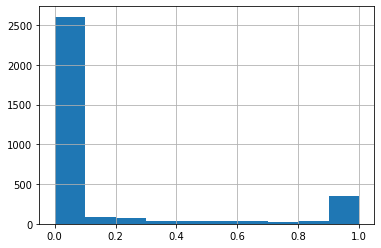

In [878]:
test_df.p_vals.hist(bins = 10)

In [639]:
fundos = fundos.value_sort('first_value')

,CNPJ_FUNDO,2002-01,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,first_value,last_value,months_existing,Taxa_Inicial,Taxa_Final,CDI_monthly_rate,mean_monthly_return,std_monthly_return,sharpe
0,01.715.238/0001-66,NaN,5.576162e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.509286,2.353692,2.399076,2.396821,2.055196,2.211379,2.402498,2.495439,2.596050,2.711145,2.783324,2.985038,2.897282,3.167228,3.298520,3.033793,2.931544,2.995698,2.989081,3.175772,3.514875,3.562343,3.734589,3.938951,4.309272,4.495917,4.530514,4.797566,4.867829,4.344825,4.552281,4.630059,4.484425,4.739208,5.042403,5.354702,5.445322,5.647105,5.495066,5.974700,6.338745,6.609491,6.963589,6.488113,6.974897,7.789402,7.846320,8.004340,7.422615,7.738972,7.614167,7.913829,8.837449,8.362329,7.380868,6.785734,6.258145,4.767733,4.466479,4.620355,4.767681,4.852497,4.815393,5.449160,6.030213,6.155572,6.163844,6.695309,6.973326,7.571886,7.834713,8.069810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002-12-01,2009-12-01,84,1.017400,2.762959,0.020780,0.018865,0.066078,-0.028990
1,02.888.554/0001-00,NaN,1.848203e+03,1873.932038,1827.773346,1852.376126,1896.233249,1956.123199,1981.278545,1981.290335,2032.491513,2211.683449,2311.90011,2389.460922,2705.905788,2994.729051,2873.338228,2842.705903,2808.090999,2507.392580,2680.858500,2855.524685,3000.362725,3152.843532,3347.574382,3446.072700,3686.683708,3662.341356,3990.650051,4197.992945,3853.110788,3720.711560,3856.592410,3928.961814,4254.101337,4714.267414,4716.725010,4990.794542,5312.806579,5956.700635,6184.87

In [885]:
fundos.shape

(3336, 255)

In [626]:
stocks["Adj Close"].reset_index()[stocks["Adj Close"].reset_index().Date == pd.to_datetime('2005-10-03')]

,Date,ABEV3.SA,BBDC3.SA,CMIG3.SA,ELET3.SA,EMBR3.SA,GGBR3.SA,ITSA3.SA,ITUB3.SA,OIBR3.SA,PETR3.SA,USIM3.SA,VALE3.SA,VIVT3.SA
733,2005-10-03,1.720666,3.333337,3.162792,2.177178,1.303787,3.491299,2.018004,3.450703,1.696191,3.362501,8.103455,2.936399,1.3376


In [559]:
fundos

,CNPJ_FUNDO,2002-01,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,first_value,last_value,months_existing,Taxa_Inicial,Taxa_Final,CDI_monthly_rate,mean_monthly_return,std_monthly_return,sharpe
0,01.715.238/0001-66,NaN,5.576162e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.509286,2.353692,2.399076,2.396821,2.055196,2.211379,2.402498,2.495439,2.596050,2.711145,2.783324,2.985038,2.897282,3.167228,3.298520,3.033793,2.931544,2.995698,2.989081,3.175772,3.514875,3.562343,3.734589,3.938951,4.309272,4.495917,4.530514,4.797566,4.867829,4.344825,4.552281,4.630059,4.484425,4.739208,5.042403,5.354702,5.445322,5.647105,5.495066,5.974700,6.338745,6.609491,6.963589,6.488113,6.974897,7.789402,7.846320,8.004340,7.422615,7.738972,7.614167,7.913829,8.837449,8.362329,7.380868,6.785734,6.258145,4.767733,4.466479,4.620355,4.767681,4.852497,4.815393,5.449160,6.030213,6.155572,6.163844,6.695309,6.973326,7.571886,7.834713,8.069810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002-12-01,2009-12-01,84,1.017400,2.762959,0.020780,0.018865,0.066078,-0.028990
1,02.888.554/0001-00,NaN,1.848203e+03,1873.932038,1827.773346,1852.376126,1896.233249,1956.123199,1981.278545,1981.290335,2032.491513,2211.683449,2311.90011,2389.460922,2705.905788,2994.729051,2873.338228,2842.705903,2808.090999,2507.392580,2680.858500,2855.524685,3000.362725,3152.843532,3347.574382,3446.072700,3686.683708,3662.341356,3990.650051,4197.992945,3853.110788,3720.711560,3856.592410,3928.961814,4254.101337,4714.267414,4716.725010,4990.794542,5312.806579,5956.700635,6184.87

To Dos:
- Get IBOV information and sample from this for the normal test (Simulate Portfolios)
- How to deal with censored data
- Idea: test for folded normal
- Read more from the literature on censored data and EMH
- Review and write down all reasons why funds were excluded
- Check Sharpe ratios are correct using software
- Check well known funds are correct (get some news)
- Repeat analysis for FIM (Impossible the way I am thinking)

In [ ]:
Post:
    - Explain Kaplan-Meier and Nelson-Aalen
    - Explain Survivorship bias
    - Explain Sharpe Ratio and why I chose it
    - Explain idea of portfolio simulation
    - Explain multiple test correction
    - Explain why restrict to FIAs